<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Simula%C3%A7%C3%A3o_motor_gaiola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

63358.41854086953


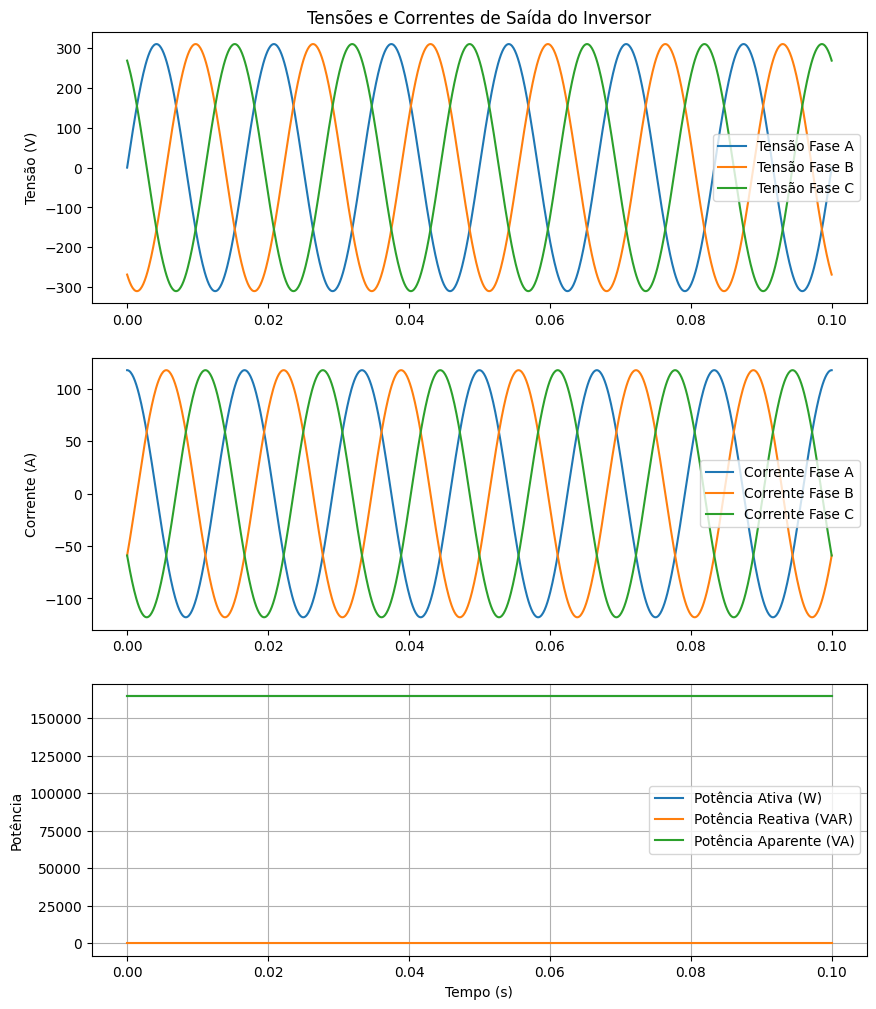

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class InversorWEGCFW300:
    def __init__(self, V_m, f, V_dc, i_dc, phi, theta, f_s, m):
        self.V_m = V_m  # Tensão de entrada RMS (V)
        self.f = f  # Frequência de entrada (Hz)
        self.V_dc = V_dc  # Tensão CC (V)
        self.i_dc = i_dc  # Corrente CC (A)
        self.phi = phi  # Ângulo de fase da tensão de entrada (rad)
        self.theta = theta  # Ângulo de fase da corrente de saída (rad)
        self.f_s = f_s  # Frequência de chaveamento (Hz)
        self.m = m  # Índice de modulação

        # Cálculo do período de chaveamento
        self.T_s = 1 / f_s

        # Cálculo do ângulo de modulação
        self.theta_m = np.arcsin(m)

        # Cálculo da frequência angular de entrada
        self.omega = 2 * np.pi * f

        # Cálculo da tensão de saída fundamental
        self.V_o1 = (2 * V_dc / np.pi) * m

    def gerar_tensoes_saida(self, t):
        u_a = self._gerar_funcao_comutacao(t, self.theta_m)
        u_b = self._gerar_funcao_comutacao(t, self.theta_m + 2 * np.pi / 3)
        u_c = self._gerar_funcao_comutacao(t, self.theta_m + 4 * np.pi / 3)

        v_sw_a = self.V_dc * u_a
        v_sw_b = self.V_dc * u_b
        v_sw_c = self.V_dc * u_c

        v_a = v_sw_a * np.sin(self.omega * t - self.phi)
        v_b = v_sw_b * np.sin(self.omega * t - self.phi - 2 * np.pi / 3)
        v_c = v_sw_c * np.sin(self.omega * t - self.phi + 2 * np.pi / 3)

        return v_a, v_b, v_c

    def gerar_correntes_saida(self, t):
        # Utilizando a mesma forma das tensões, por simplicidade
        i_a, i_b, i_c = self.gerar_tensoes_saida(t)
        i_a = self.i_dc * np.sin(self.omega * t - self.theta + np.pi/2)
        i_b = self.i_dc * np.sin(self.omega * t - self.theta - 2 * np.pi / 3 + np.pi/2)
        i_c = self.i_dc * np.sin(self.omega * t - self.theta + 2 * np.pi / 3 + np.pi/2)
        return i_a, i_b, i_c

    def calcular_potencias(self, v_a, v_b, v_c, i_a, i_b, i_c):
        V_ef = np.sqrt(np.mean(v_a**2 + v_b**2 + v_c**2))
        I_ef = np.sqrt(np.mean(i_a**2 + i_b**2 + i_c**2))
        P = 3 * V_ef * I_ef * np.cos(0)
        Q = np.mean(v_a * i_a * np.sin(self.phi)) + np.mean(v_b * i_b * np.sin(self.phi)) + np.mean(v_c * i_c * np.sin(self.phi))
        S = np.sqrt(P**2 + Q**2)
        return P, Q, S

    def _gerar_funcao_comutacao(self, t, theta_m):
        k = np.floor((t + self.T_s / 4) / self.T_s)
        u = (t < (k * self.T_s + theta_m)).astype(int)
        return u

# Parâmetros do inversor
V_m = 220
f = 60
V_dc = 310
i_dc = 118
phi = 0
theta = 0
f_s = 100
m = 0.01

t_sim = 0.1
t = np.linspace(0, t_sim, 1000)

inversor = InversorWEGCFW300(V_m, f, V_dc, i_dc, phi, theta, f_s, m)

v_a, v_b, v_c = inversor.gerar_tensoes_saida(t)
i_a, i_b, i_c = inversor.gerar_correntes_saida(t)
Pin= np.sqrt(3) * V_dc * i_dc * np.cos(0)
print(Pin)
Pa, Q, S = inversor.calcular_potencias(v_a, v_b, v_c, i_a, i_b, i_c)

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
plt.plot(t, v_a, label='Tensão Fase A')
plt.plot(t, v_b, label='Tensão Fase B')
plt.plot(t, v_c, label='Tensão Fase C')
plt.title('Tensões e Correntes de Saída do Inversor')
plt.ylabel('Tensão (V)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, i_a, label='Corrente Fase A')
plt.plot(t, i_b, label='Corrente Fase B')
plt.plot(t, i_c, label='Corrente Fase C')
plt.ylabel('Corrente (A)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, np.full_like(t, Pa), label='Potência Ativa (W)')
plt.plot(t, np.full_like(t, Q), label='Potência Reativa (VAR)')
plt.plot(t, np.full_like(t, S), label='Potência Aparente (VA)')
plt.xlabel('Tempo (s)')
plt.ylabel('Potência')
plt.legend()

plt.grid(True)
plt.show()


Escorregamento máximo e torque: s=0.10400000000000001, Torque=72.39220370898904 Nm
Velocidade Sincrona: 301.59289474462014 (rad/s) ou 2880.0RPM


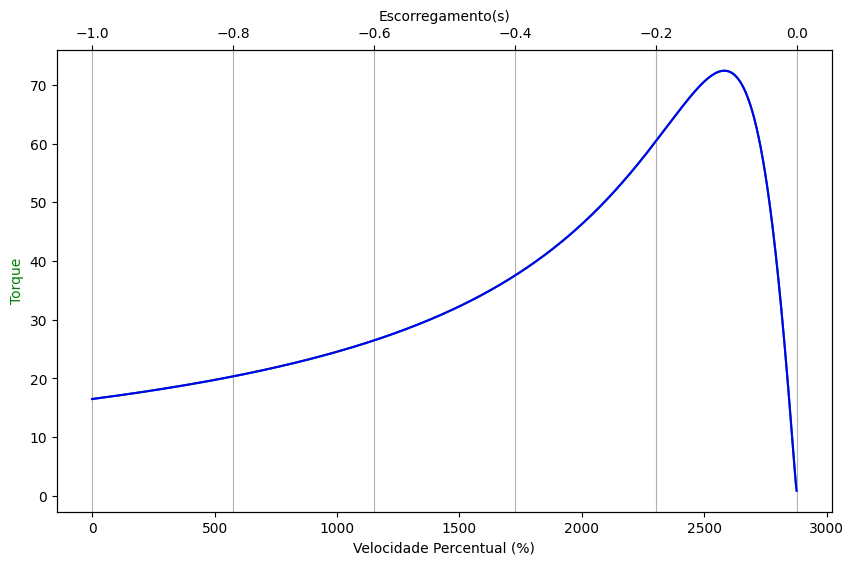

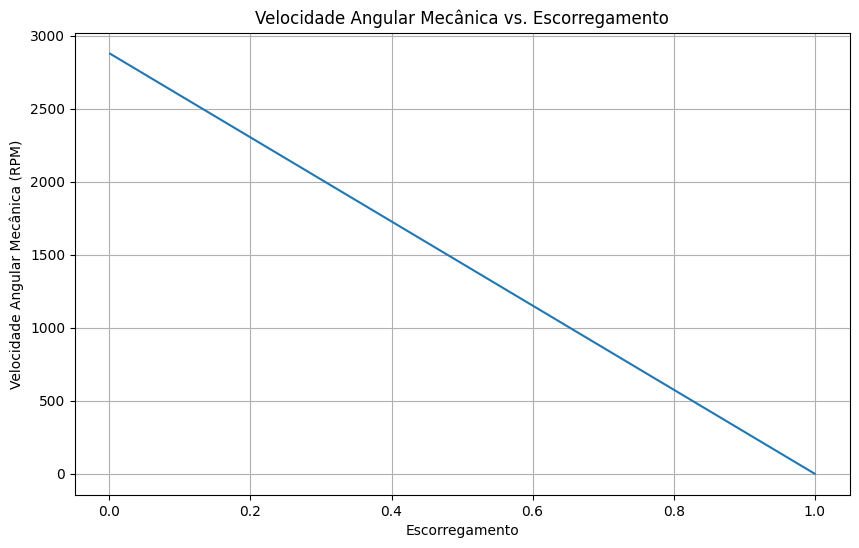

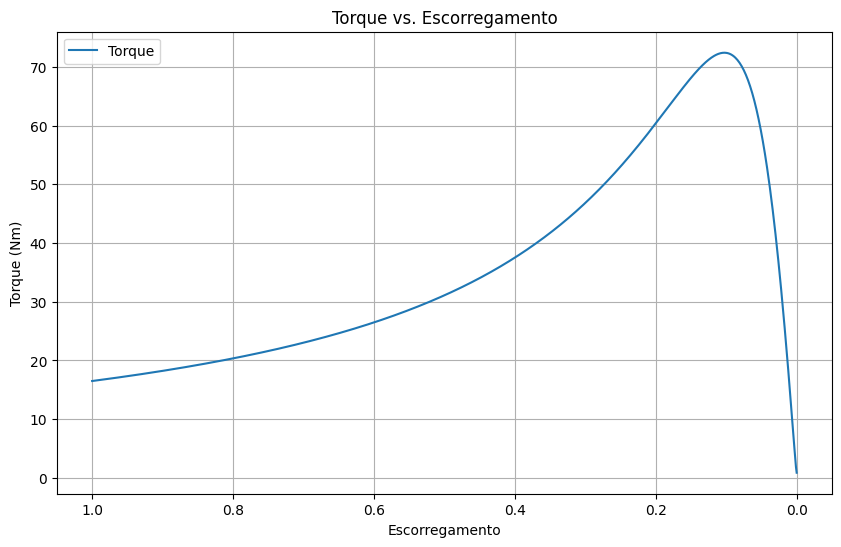

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


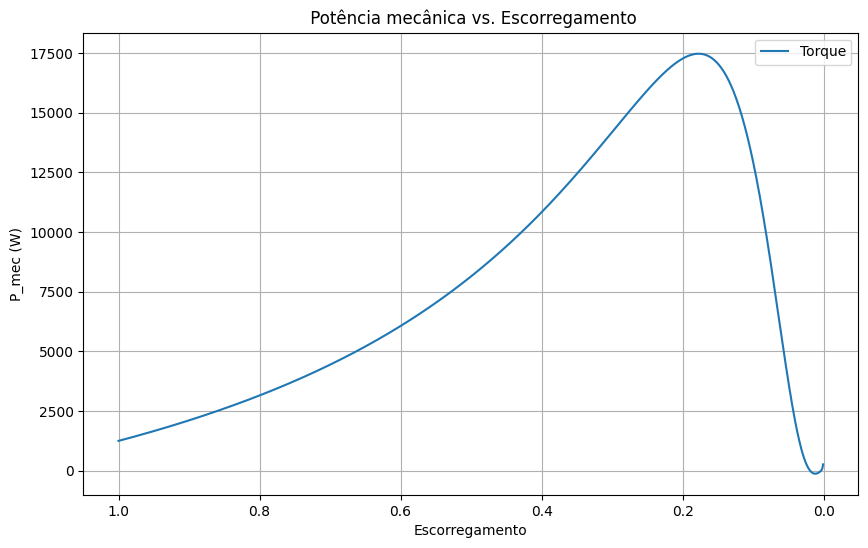

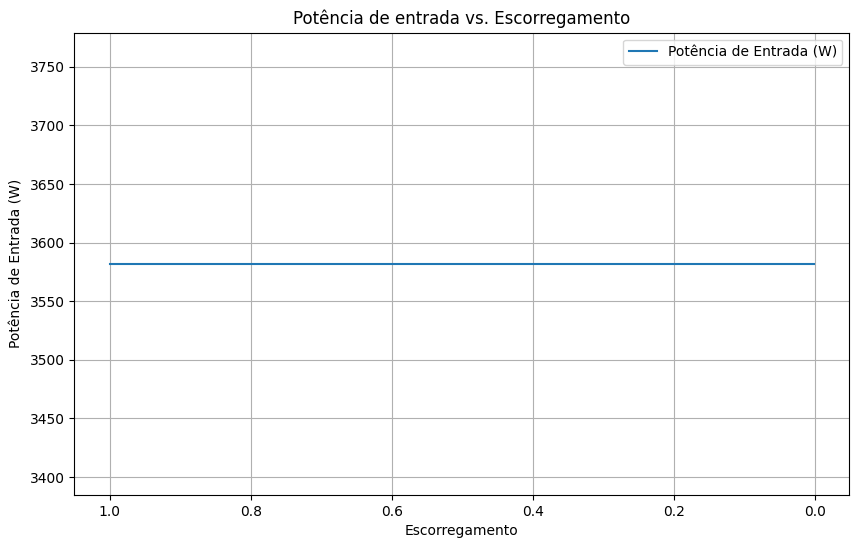

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmath  # Para operações com números complexos

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1, Z2 , Zm, Z2_prime

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_corrente1(self, V_fase, s):
        Z1 = self.calcular_impedancia(s)[1]
        I_fase1 = V_fase / Z1
        return I_fase1

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_partida(self, V_fase, s):
        Im = self.calcular_tensao_induzida(V_fase, s) / self.Xm
        I2 = self.calcular_corrente(V_fase, s) - Im
        return I2

    def calcular_potencia(self, V_fase, s):
        I_fase = self.calcular_corrente1(V_fase, s)
        P_fase = V_fase * I_fase * 1
        return P_fase


    def calcular_torque(self, V_fase, s):

        # Corrente do estator
        #I_1 = calcular_corrente(V_fase, s)

        # Tensão induzida no rotor
        E2 = self.calcular_tensao_induzida(V_fase, s)
        #Z1 = self.calcular_impedancia(s)[1]
        #E2 = V_fase - I_1*Z1

        # Corrente do rotor
        I2 = self.calcular_corrente_de_partida(V_fase, s)

        # Potência no rotor e torque
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / self.w_s

        return self.K * torque  # Aplica a constante de proporcionalidade

    def calcular_perdas(self, s):
        I2= self.calcular_corrente_de_partida(220, s)
        perdaR = (I2**2) *self.calcular_impedancia(s)[4]
        return perdaR

    def encontrar_maior_torque(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        max_torque = max(torques)
        max_s = escorregamentos[torques.index(max_torque)]
        return max_s, max_torque

    def calcular_velocidade_angular(self, escorregamentos):
        return (self.w_s * (1 - escorregamentos)) * (30 / np.pi)

    def simular_desempenho(self, V_fase, escorregamentos):
        torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
        plt.figure(figsize=(10, 5))
        plt.plot(escorregamentos, torques, label='Torque (Nm)')
        plt.title('Torque vs. Escorregamento')
        plt.xlabel('Escorregamento')
        plt.ylabel('Torque (Nm)')
        plt.grid(True)
        plt.show()

# Exemplo de uso
frequencia = 48  # frequência em Hz
P = 2  # Número de polos
R1 = 0.135  # Resistência do estator
X1 = 0.768  # Reatância do estator
R2 = 0.0916  # Resistência do rotor
X2 = 0.123  # Reatância do rotor
Xm = 142.3  # Reatância magnética
K = 0.95  # Constante de proporcionalidade para o torque ajustada para exemplo

# Instanciação do motor
motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K)

# Tensão aplicada (exemplo)
V_fase = V_m / np.sqrt(3)  # Tensão de fase (V) a partir de uma tensão de linha de 220V

PotenciaA=MotorDeGaiola.calcular_potencia(motor,V_fase,1)

# Simular o desempenho do motor para uma faixa de escorregamentos
escorregamentos = np.linspace(0.001, 1, 1000)
torques = [motor.calcular_torque(V_fase, s) for s in escorregamentos]

# Encontrar maior torque
s_max, torque_max = motor.encontrar_maior_torque(V_fase, escorregamentos)

print(f"Escorregamento máximo e torque: s={s_max}, Torque={torque_max} Nm")
print(f"Velocidade Sincrona: {motor.w_s} (rad/s) ou {(motor.w_s)*30/np.pi}RPM")

# Calcular a velocidade percentual
velocidades_percentuais = (1 - escorregamentos) * ((motor.w_s)*30/np.pi)

esp=np.abs(-escorregamentos)

# Plotagem de Torque vs. Velocidade Percentual
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotar dados no primeiro eixo
ax1.plot(velocidades_percentuais,torques, 'g-')
ax1.set_xlabel('Velocidade Percentual (%)')
ax1.set_ylabel('Torque', color='g')
# Adicionar um segundo eixo x em cima
ax2 = ax1.twiny()
ax2.plot(-esp, torques, 'b-')
ax2.set_xlabel('Escorregamento(s)')
plt.grid(True)
plt.show()

print('\n')

# Calcular e plotar a velocidade angular mecânica vs. escorregamento
velocidades_angulares = motor.calcular_velocidade_angular(escorregamentos)
perdas=motor.calcular_perdas(escorregamentos)
P_mec=torques*(velocidades_angulares*(np.pi/30)) - perdas



plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, velocidades_angulares)
plt.title('Velocidade Angular Mecânica vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Velocidade Angular Mecânica (RPM)')
plt.grid(True)
plt.show()

print('\n')

# Plotagem de Torque vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, torques, label='Torque')
plt.title('Torque vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

# Plotagem de Torque vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, P_mec , label='Torque')
plt.title(' Potência mecânica vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('P_mec (W)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


# Calcular potência para cada escorregamento
potencias = [motor.calcular_potencia(V_fase, s).real for s in escorregamentos]  # Parte real da potência

# Plotagem de Potência vs. Escorregamento
plt.figure(figsize=(10, 6))
plt.plot(escorregamentos, potencias, label='Potência de Entrada (W)')
plt.title('Potência de entrada vs. Escorregamento')
plt.xlabel('Escorregamento')
plt.ylabel('Potência de Entrada (W)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


<Figure size 1800x800 with 0 Axes>

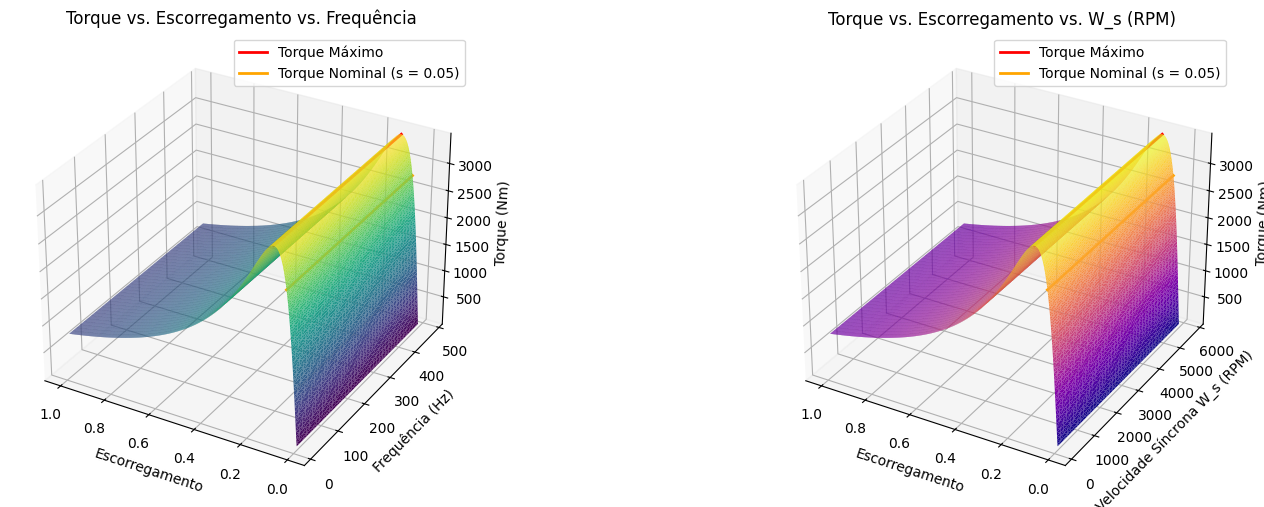

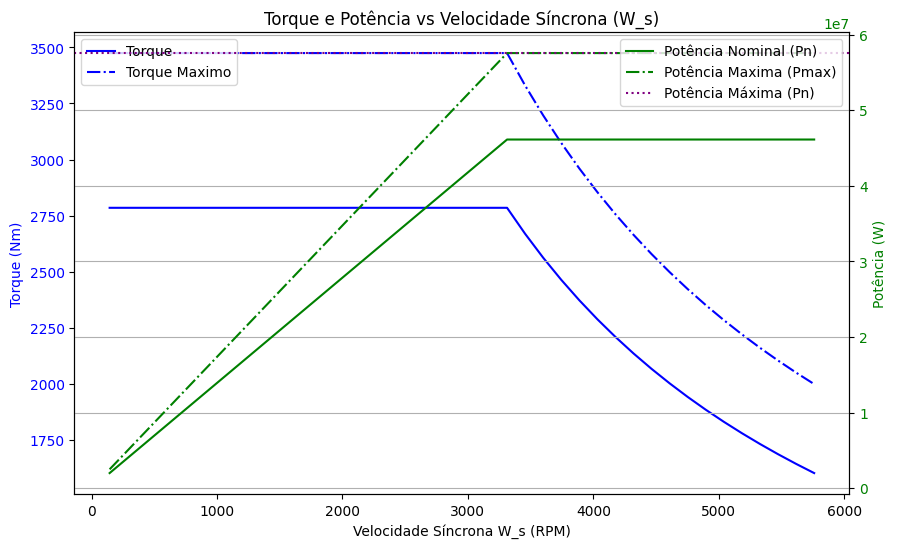

In [5]:
from os import wait
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cmath  # Para operações com números complexos

class MotorDeGaiola:
    def __init__(self, frequencia, freqs, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.freqs = freqs
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.freqs / (self.P / 2)  # Velocidade síncrona

    def set_frequencia(self, frequencia):
        """Atualiza a frequência e recalcula a velocidade síncrona."""
        self.freqs = freqs
        self.w_s = 2 * np.pi * self.freqs / (self.P / 2)
        return self.freqs, self.w_s

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 + Z2_prime, Z1

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[0]
        I_fase = V_fase / Z
        return I_fase

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[1]
        return E2

    def calcular_corrente_de_partida(self, V_fase, s):
        Im = self.calcular_tensao_induzida(V_fase, s) / self.Xm
        I2 = self.calcular_corrente(V_fase, s) - Im
        return I2

    def calcular_torque(self, V_fase, s):
        E2 = self.calcular_tensao_induzida(V_fase, s)
        I2 = self.calcular_corrente_de_partida(V_fase, s)
        P_r = 3 * abs(I2)**2 * (self.R2 / s)
        torque = P_r / self.w_s

        return self.K * torque  # Aplica a constante de proporcionalidade

    def simular_frequencias(self, V_fase, escorregamentos, freq_min=1, freq_max=360, passo=60):
        """Simula o desempenho do motor para uma faixa de frequências e plota as curvas de torque."""
        plt.figure(figsize=(18, 8))
        all_torques = []
        all_torques_max = []
        all_torques_nominal = []
        all_frequencies = []
        all_pn = []
        all_pmax = []
        Wss = []

        for freqs in range(freq_min, freq_max + 1, passo):
            self.set_frequencia(freqs)
            torques = [self.calcular_torque(V_fase, s) for s in escorregamentos]
            all_torques.append(torques)
            all_frequencies.append([freqs] * len(escorregamentos))

            # Encontrar índice do escorregamento próximo de 0.05
            idx_nominal = np.where(np.isclose(escorregamentos, 0.05, atol=0.0001))[0]
            torque_nominal = torques[idx_nominal[0]] if len(idx_nominal) > 0 else None
            torque_max = max(torques)

            # Calcular potência nominal e potência máxima
            pn = (torque_nominal * (freqs * 120) / self.P) if torque_nominal is not None else None
            pmax = torque_max * (freqs * 120) / self.P

            # Verificar limites de potência
            if pn is not None and pn <= 46112518.40388375 and pmax <= 5.75431149e+07:
                all_pn.append(pn)
                all_pmax.append(pmax)
                all_torques_nominal.append(torque_nominal)
                all_torques_max.append(torque_max)
                Wss.append((freqs * 2 * 60) / (self.P / 2)/10)
            else:
                all_pn.append(46112518.40388375)
                all_pmax.append(5.75431149e+07)
                all_torques_nominal.append(46112518.40388375 / ((freqs * 120) / self.P))
                all_torques_max.append(5.75431149e+07 / ((freqs * 120) / self.P))
                Wss.append((freqs * 2 * 60) / (self.P / 2)/10)

        return (
            np.array(all_frequencies).flatten(),
            np.array(all_torques).flatten(),
            np.tile(escorregamentos, len(range(freq_min, freq_max + 1, passo))),
            np.array(all_pn).flatten(),
            np.array(all_pmax).flatten(),
            np.array(all_torques_nominal),
            np.array(all_torques_max),
            np.array(Wss)
        )

    def plotar_3d_torque_escorregamento_frequencia(self, V_fase, escorregamentos, freq_min=12, freq_max=120, passo=12):
        """Plota gráficos 3D de Torque vs Escorregamento vs Frequência e Torque vs Escorregamento vs W_s (RPM)."""
        frequencies, torques, escorregamentos_flat, Pn, Pmax, Tnominal, Tmaximo , Wss= self.simular_frequencias(V_fase, escorregamentos, freq_min, freq_max, passo)

        # Gráfico 3D de Torque x Escorregamento x Frequência
        fig = plt.figure(figsize=(18, 6))
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.plot_trisurf(escorregamentos_flat, frequencies, torques, cmap='viridis')
        ax1.set_title('Torque vs. Escorregamento vs. Frequência')
        ax1.set_xlabel('Escorregamento')
        ax1.set_ylabel('Frequência (Hz)')
        ax1.set_zlabel('Torque (Nm)')
        ax1.invert_xaxis()

        # Determinar o escorregamento correspondente ao torque máximo
        idx_torque_maximo = np.argmax(torques)
        escorregamento_torque_maximo = escorregamentos_flat[idx_torque_maximo]

        # Adicionar linha para torque máximo (paralela às frequências)
        ax1.plot(
            [escorregamento_torque_maximo] * 2,  # Fixar no escorregamento do torque máximo
            [freq_min, freq_max],               # Variar ao longo das frequências
            [Tmaximo[0], Tmaximo[19]],     # Valor constante do torque máximo
            color='red', linewidth=2, label='Torque Máximo'
        )

        # Adicionar linha para torque nominal (s = 0.05)
        escorreg_nominal = 0.05
        ax1.plot(
            [escorreg_nominal] * 2,             # Fixar no escorregamento nominal
            [freq_min, freq_max],               # Variar ao longo das frequências
            [Tnominal[0], Tnominal[19]],  # Valor constante do torque nominal
            color='orange', linewidth=2, label='Torque Nominal (s = 0.05)'
        )
        ax1.legend()

        W_RPM =((frequencies *2 *60)/(self.P/2)/10 )


        # Gráfico 3D de Torque x Escorregamento x W_s (RPM)
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot_trisurf(escorregamentos_flat,W_RPM , torques, cmap='plasma')
        ax2.set_title('Torque vs. Escorregamento vs. W_s (RPM)')
        ax2.set_xlabel('Escorregamento')
        ax2.set_ylabel('Velocidade Síncrona W_s (RPM)')
        ax2.set_zlabel('Torque (Nm)')
        ax2.invert_xaxis()

        # Adicionar linha para torque máximo no gráfico de W_s (RPM)
        ax2.plot(
            [escorregamento_torque_maximo] * 2,  # Fixar no escorregamento do torque máximo
            [np.min(W_RPM), np.max(W_RPM)],   # Variar ao longo do RPM
            [Tmaximo[0], Tmaximo[19]],     # Valor constante do torque máximo
            color='red', linewidth=2, label='Torque Máximo'
        )

        # Adicionar linha para torque nominal no gráfico de W_s (RPM)
        ax2.plot(
            [escorreg_nominal] * 2,             # Fixar no escorregamento nominal
            [np.min(W_RPM), np.max(W_RPM)],   # Variar ao longo do RPM
            [Tnominal[0], Tnominal[0]],  # Valor constante do torque nominal
            color='orange', linewidth=2, label='Torque Nominal (s = 0.05)'
        )
        ax2.legend()

        # Gráfico combinado de Torque e Potência
        fig, ax1 = plt.subplots(figsize=(10, 6))
        W_RPM = np.resize(W_RPM, len(Pn))

        # Plotar torque nominal e torque máximo no mesmo gráfico
        ax1.plot(Wss, Tnominal, label="Torque", color="blue", linewidth=1.5, ls='-' )
        ax1.plot(Wss, Tmaximo, label="Torque Maximo", color="blue", linewidth=1.5, ls='-.' )
        ax1.set_xlabel("Velocidade Síncrona W_s (RPM)")
        ax1.set_ylabel("Torque (Nm)", color="blue")
        ax1.tick_params(axis="y", labelcolor="blue")
        ax1.legend(loc="upper left")

        # Segundo eixo para Pn
        ax2 = ax1.twinx()
        ax2.plot(Wss, Pn, label="Potência Nominal (Pn)", color="green", linestyle="-", linewidth=1.5)
        ax2.plot(Wss, Pmax, label="Potência Maxima (Pmax)", color="green", linestyle="-.", linewidth=1.5)
        ax2.set_ylabel("Potência (W)", color="green")
        ax2.tick_params(axis="y", labelcolor="green")
        ax2.axhline(np.max(Pmax), color="purple", linestyle=":", label="Potência Máxima (Pn)")
        ax2.legend(loc="upper right")

        # Configurações adicionais do gráfico
        plt.title("Torque e Potência vs Velocidade Síncrona (W_s)")
        plt.grid()

        plt.show()


# Exemplo de uso
frequencia = 60  # Frequência inicial em Hz
freqs = 1
P = 2  # Número de polos
R1 = 0.135  # Resistência do estator
X1 = 0.768  # Reatância do estator
R2 = 0.0916  # Resistência do rotor
X2 = 0.123  # Reatância do rotor
Xm = 142.3  # Reatância magnética
K = 0.95  # Constante de proporcionalidade para o torque ajustada para exemplo

# Instanciação do motor
motor = MotorDeGaiola(frequencia, freqs, P, R1, X1, R2, X2, Xm, K)

# Tensão aplicada (exemplo)
V_fase = 220 / np.sqrt(3)  # Tensão de fase (V) a partir de uma tensão de linha de 220V

# Simular e plotar em 3D o desempenho do motor para uma faixa de escorregamentos e frequências
escorregamentos = np.linspace(1, 0.001, 1000)
motor.plotar_3d_torque_escorregamento_frequencia(V_fase, escorregamentos, freq_min=12, freq_max=480, passo=12)
